# Counts Analysis

Co-occurence of terms analysis: check how often pre-selected cognitive terms appear in abstracts with ERP terms. 

This analysis searches through pubmed for papers that contain specified ERP and selected association terms.

Data extracted is the count of the number of papers with both terms. This is used to infer the associated terms for each ERP.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import normaltest
from sklearn.metrics.pairwise import cosine_similarity

from lisc import Counts
from lisc.utils import load_object
from lisc.plts.counts import plot_matrix, plot_clustermap, plot_dendrogram

from plts.group import plot_count_hist, plot_time_assocs

## Setup

In [2]:
# Settings
CUR_DATA = 'load'               # 'load', 'file', 'test'
TERM_TYPE = 'cognitive'         # 'cognitive', 'disease'
SAVE_FIG = False

In [3]:
# Set the location of the terms
term_dir = '../terms/'

In [4]:
# Initialize object for term count co-occurences
counts = Counts()

In [5]:
# Load ERPS and terms from file
if CUR_DATA == 'file':

    counts.add_terms_file('erps.txt', dim='A', directory=term_dir)
    counts.add_terms_file('cognitive.txt', dim='B', directory=term_dir)    

# OR: Set small set of ERPs and terms for tests
elif CUR_DATA == 'test':

    # Small test set of words
    erps = [['P100', 'P1'], 'N400']
    excludes = ['', ['protein', 'gene', 'cell']]
    cog_terms = ['language', 'memory'] 

    # Add ERPs and terms
    counts.add_terms(erps, dim='A')
    counts.add_terms(excludes, term_type='exclusions', dim='A')
    counts.add_terms(cog_terms, dim='B')

# Load from pickle file
elif CUR_DATA == 'load':

    name = 'DisScrape.p'
    counts = load_object(name)#, directory='.')

else: 
    raise ValueError('Data setting not understood.')

In [6]:
# If not loading, run the scrape
if CUR_DATA in ['file', 'test']:
    
    # Scrape the co-occurence of terms data
    counts.run_collection(db='pubmed', verbose=True)
    
    # Save pickle file of results
    save_object(counts, 'test2')

## Scrape Information

In [7]:
# Check database information
counts.meta_data.db_info

{'dbname': 'pubmed',
 'menuname': 'PubMed',
 'description': 'PubMed bibliographic record',
 'dbbuild': 'Build210119-2212m.3',
 'count': '32034250',
 'lastupdate': '2021/01/20 15:07'}

In [8]:
# Check requester details
counts.meta_data.requester

{'n_requests': 11,
 'wait_time': 0.3333333333333333,
 'start_time': '15:43:57 Thursday 21 January 2021',
 'end_time': '15:44:03 Thursday 21 January 2021',
 'logging': None}

# Global Summaries

The total # of ERP papers is 		 2081


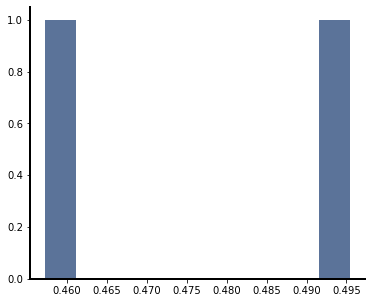

In [9]:
# Check the distribution of ERP papers
print('The total # of ERP papers is \t\t {:.0f}'.format(sum(counts.terms['A'].counts)))
#print('Test for normality (log-spaced) \t t-val: {:1.2f} \t p-val {:1.2f}'.format(\
#    *normaltest(np.log10(counts.terms['A'].counts))))
plot_count_hist(np.log10(counts.terms['A'].counts))

The total # of association papers is 		 591863


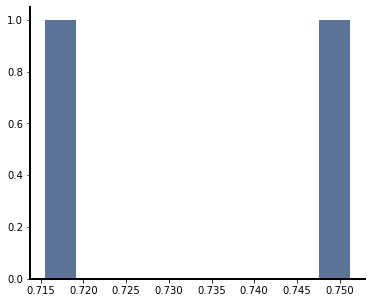

In [10]:
# Check the distribution of ERP papers
print('The total # of association papers is \t\t {:.0f}'.format(sum(counts.terms['B'].counts)))
#print('Test for normality (log-spaced) \t t-val: {:1.2f} \t p-val {:1.2f}'.format(\
#    *normaltest(np.log10(counts.terms['B'].counts))))
plot_count_hist(np.log10(counts.terms['B'].counts))

# Check Counts

In [11]:
# Check the terms with the most papers
counts.check_top(dim='A')
counts.check_top(dim='B')

The most studied term is  'N170'  with  1346  articles.
The most studied term is  'visual'  with  435325  articles.


In [12]:
# Check how many papers were found for each ERP term
counts.check_counts(dim='A')

The number of documents found for each search term is:
  'P600'   -    735
  'N170'   -   1346


In [13]:
# Check how many papers were found for each association term
counts.check_counts(dim='B')

The number of documents found for each search term is:
  'language'   -   156538
  'visual'     -   435325


In [14]:
# Check the most commonly associated association term for each ERP
counts.check_data()

For  'P600'  the highest association is  'language'  with         316
For  'N170'  the highest association is  'visual'    with         558


In [15]:
# Check the most commonly associated ERP for each term
counts.check_data(dim='B')

For  'language'  the highest association is  'P600'  with         316
For  'visual'    the highest association is  'N170'  with         558


## Select ERPs with enough articles

In [16]:
# Check how many ERPs currently
counts.terms['A'].n_terms

2

In [17]:
# Drop to only keep ERPs with at least 50 papers
counts.drop_data(50, dim='A')
counts.terms['A'].n_terms

2

## Group Level Plots

In [18]:
# Compute the normalized score (percent association)
counts.compute_score('normalize')

In [19]:
# Grab labels, for convenience
erp_labels = counts.terms['A'].labels
term_labels = counts.terms['B'].labels

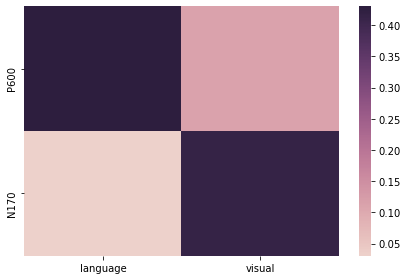

In [20]:
# Plot the matrix of percent associations - ERPs & terms
plot_matrix(counts.score, term_labels, erp_labels)#, figsize=(4, 4))

### Similarity across ERPs & terms

In [21]:
# Calculate similarity between all ERPs (based on term association percents)
sim_erps = cosine_similarity(counts.score)

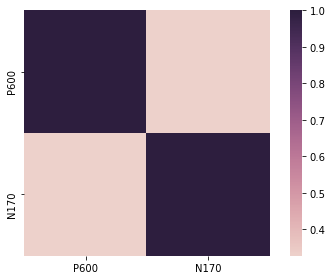

In [22]:
# Plot similarity matrix between ERPs
plot_matrix(sim_erps, erp_labels, erp_labels, square=True)#, figsize=(4, 4))

In [23]:
# Calculate similarity between all terms (based on their associated ERPs)
sim_terms = cosine_similarity(counts.score.T)

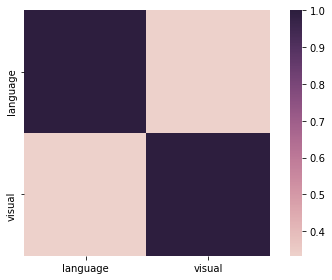

In [24]:
# Plot similarity matrix between ERPs
plot_matrix(sim_terms, term_labels, term_labels, square=True)

### Clustermaps

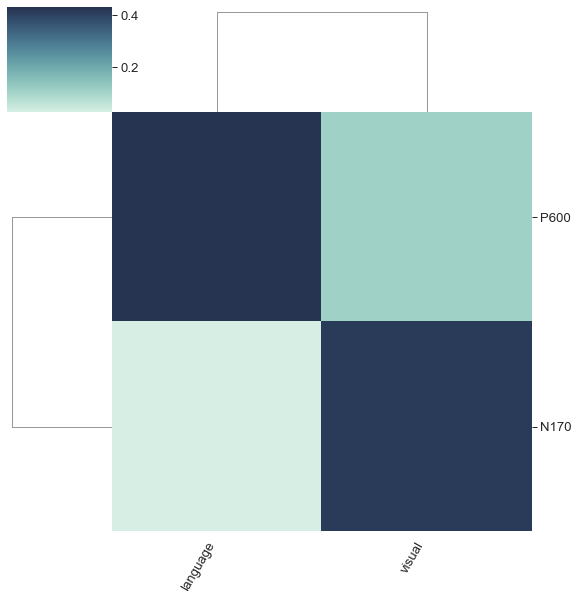

In [25]:
# Plot a clustermap, clustering ERPs and terms based on similarity
plot_clustermap(counts.score, term_labels, erp_labels, cmap='blue')

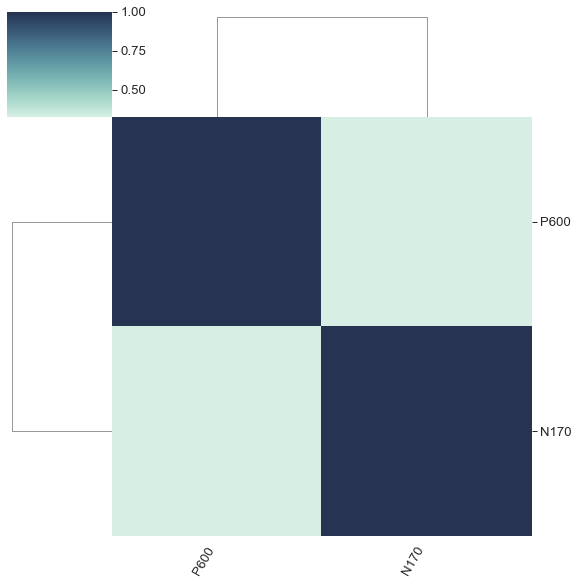

In [26]:
# Clustermap of ERP similarity
plot_clustermap(sim_erps, erp_labels, erp_labels, 'blue', save_fig=SAVE_FIG)

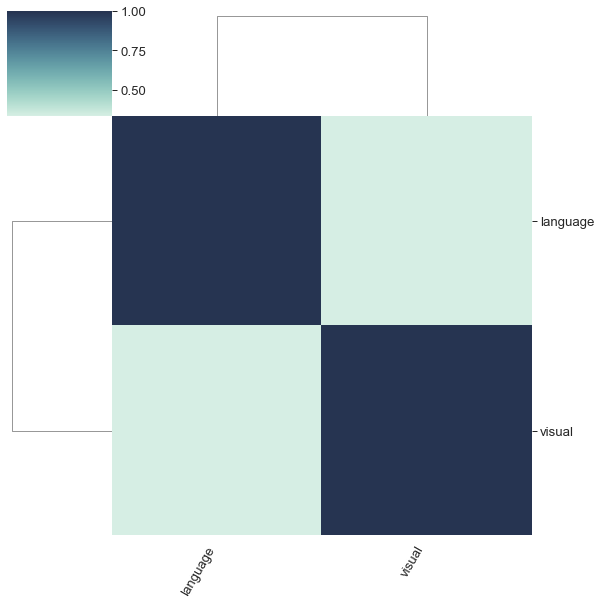

In [27]:
# Plot the clustermap of term similarity
plot_clustermap(sim_terms, term_labels, term_labels, 'blue', save_fig=SAVE_FIG)

### Dendrograms

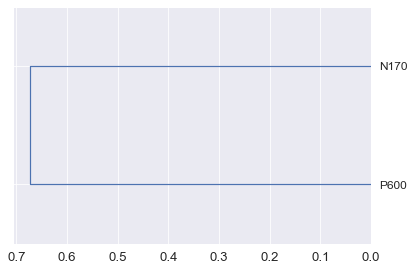

In [28]:
# Plot dendrogram of ERPs, based on percent associations with terms
plot_dendrogram(counts.score, erp_labels)

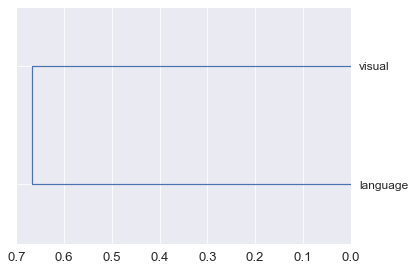

In [29]:
# Plot dendrogram of termss, based on percent associations with ERPs
plot_dendrogram(counts.score.T, term_labels)

### Function correlates across time

In [30]:
# Drop to most common ERPs, and check how many are left
counts.drop_data(100)
counts.terms['A'].n_terms

2

In [31]:
import numpy as np

def extract_time_associations(counts):
    """Get time associations from canonically named ERP components."""
    
    time_associations = []
    
    for erp_ind, erp in enumerate(counts.terms['A'].labels):

        # List is: [word, P or N, latency]
        temp  = [None, None, None]

        # Get P/N & latency for ERPs with naming convention
        if erp[1:].isdigit():

            # Get P or N
            if erp[0] == 'P':
                temp[1] = 'P'
            elif erp[0] == 'N':
                temp[1] = 'N' 

            # Get latency
            temp[2] = int(erp[1:])

            # Get association
            term_ind = np.argmax(counts.score[erp_ind, :])
            temp[0] = counts.terms['B'].terms[term_ind][0]

            # Collect ERP data
            time_associations.append(temp)
    
    return time_associations

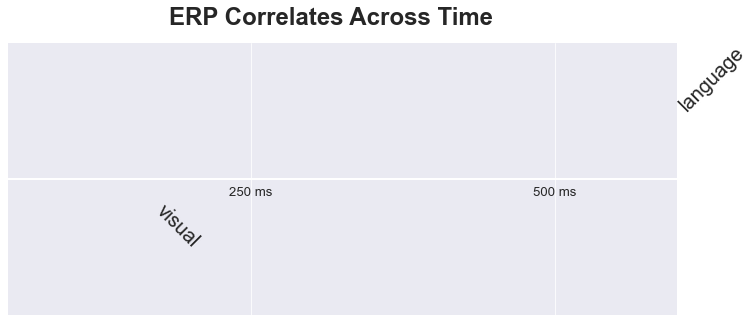

In [32]:
time_associations = extract_time_associations(counts)
plot_time_assocs(time_associations)